# Esta notebook fue la que utilice para Hacer el entrenamiento y la validacion del modelo
## Importante: este archivo fue implementado en kaggle dada la mayor potencia de GPU Y RAM


In [1]:
!nvidia-smi

Sun Jul 28 19:47:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


## Instalar YOLOv10

In [3]:
!pip install -q supervision

In [4]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

## Descargar los modelos Pre Entrenados

In [5]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-r--r-- 1 root root  80M May 23 09:38 yolov10b.pt
-rw-r--r-- 1 root root 100M May 23 09:38 yolov10l.pt
-rw-r--r-- 1 root root  64M May 23 09:38 yolov10m.pt
-rw-r--r-- 1 root root  11M May 23 09:38 yolov10n.pt
-rw-r--r-- 1 root root  32M May 23 09:38 yolov10s.pt
-rw-r--r-- 1 root root 123M May 23 09:38 yolov10x.pt


## Descargar el dataset de Roboflow

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rqEEbQ3v07shQHxl51l0")
project = rf.workspace("tptruco").project("cards-wltoo")
version = project.version(1)
dataset = version.download("yolov9")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.2.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.


Extracting Dataset Version Zip to Cards-1 in yolov9:: 100%|██████████| 4847/4847 [00:00<00:00, 6412.70it/s]


## Custom Training

In [7]:
import os
import shutil
from PIL import Image

def create_directories():
    if not os.path.exists('/kaggle/working/Cards-1/label_errors'):
        os.makedirs('/kaggle/working/Cards-1/label_errors')

def load_annotations(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    annotations = [line.strip().split() for line in lines]
    return annotations

def validate_bounding_box(x_center, y_center, width, height):
    if (x_center - width / 2 < 0 or x_center + width / 2 > 1 or
        y_center - height / 2 < 0 or y_center + height / 2 > 1):
        return False
    return True

# Convertir anotaciones al formato YOLOv5
def convert_to_yolo_format(bbox):
    if len(bbox) == 11:
        # Extraer coordenadas de los vértices
        x1, y1 = float(bbox[1]), float(bbox[2])
        x2, y2 = float(bbox[3]), float(bbox[4])
        x3, y3 = float(bbox[5]), float(bbox[6])
        x4, y4 = float(bbox[7]), float(bbox[8])
        
        # Calcular centro, ancho y alto
        x_center = (x1 + x2 + x3 + x4) / 4
        y_center = (y1 + y2 + y3 + y4) / 4
        width = max(x1, x2, x3, x4) - min(x1, x2, x3, x4)
        height = max(y1, y2, y3, y4) - min(y1, y2, y3, y4)
        
        # Devolver en formato YOLOv5
        return [bbox[0], str(x_center), str(y_center), str(width), str(height)]
    elif len(bbox) == 9:
        # Extraer coordenadas mínimas y máximas
        x_min, y_min = float(bbox[1]), float(bbox[2])
        x_max, y_max = float(bbox[5]), float(bbox[6])
        
        # Calcular centro, ancho y alto
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        
        # Devolver en formato YOLOv5
        return [bbox[0], str(x_center), str(y_center), str(width), str(height)]
    elif len(bbox) == 5:
        return bbox 
    else:
        raise ValueError("Formato de anotación no reconocido.p")

def save_annotations(file_path, annotations):
    with open(file_path, 'w') as file:
        for annotation in annotations:
            file.write(' '.join(annotation) + '\n')

def main():
    create_directories()
    annotations_path = '/kaggle/working/Cards-1/train/labels'
    images_path = '/kaggle/working/Cards-1/train/images'
    
    for filename in os.listdir(annotations_path):
        if filename.endswith('.txt'):
            annotation_file = os.path.join(annotations_path, filename)
            image_file = os.path.join(images_path, filename.replace('.txt', '.jpg'))
            
            if not os.path.exists(image_file):
                print(f"Image file {image_file} does not exist.")
                continue
            
            annotations = load_annotations(annotation_file)
            
            valid_annotations = []
            errors_found = False
            
            for annotation in annotations:
                try:
                    if len(annotation) == 11:
                        converted_annotation = convert_to_yolo_format(annotation)
                        x_center, y_center, width, height = map(float, converted_annotation[1:5])
                    elif len(annotation) == 9:
                        converted_annotation = convert_to_yolo_format(annotation)
                        x_center, y_center, width, height = map(float, converted_annotation[1:5])
                    elif len(annotation) == 5:
                        x_center, y_center, width, height = map(float, annotation[1:5])
                        converted_annotation = annotation 
                    else:
                        print(len(annotation))
                        raise ValueError("Formato de anotación no reconocido.y")
                    
                    if not validate_bounding_box(x_center, y_center, width, height):
                        errors_found = True
                        break
                    
                    valid_annotations.append(converted_annotation)
                except Exception as e:
                    print(f"Error processing annotation {annotation} in file {annotation_file}: {e}")
                    errors_found = True
                    break
            
            if errors_found:
                shutil.move(annotation_file, os.path.join('/kaggle/working/Cards-1/label_errors', filename))
                shutil.move(image_file, os.path.join('/kaggle/working/Cards-1/label_errors', os.path.basename(image_file)))
            else:
                save_annotations(annotation_file, valid_annotations)

if __name__ == '__main__':
    main()

In [8]:
import yaml

# Path to the YAML file
yaml_file_path = "/kaggle/working/Cards-1/data.yaml"

# Load the YAML file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)

# Modify the 'train' and 'val' paths
data['train'] = "/kaggle/working/" + data['train']
data['val'] = "/kaggle/working/" + data['val']

# Write the updated content back to the YAML file
with open(yaml_file_path, 'w') as file:
    yaml.safe_dump(data, file)

print("YAML file updated successfully.")


YAML file updated successfully.


In [9]:
%cd {HOME}

import os
os.environ['WANDB_MODE'] = 'disabled'

!yolo task=detect mode=train epochs=10 batch=11 plots=True \
model={HOME}/weights/yolov10x.pt \
data={dataset.location}/data.yaml

/kaggle/working
New https://pypi.org/project/ultralytics/8.2.68 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10x.pt, data=/kaggle/working/Cards-1/data.yaml, epochs=10, time=None, patience=100, batch=11, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fals

In [10]:
!ls {HOME}/runs/detect/train/

F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
args.yaml					   val_batch0_labels.jpg
confusion_matrix.png				   val_batch0_pred.jpg
confusion_matrix_normalized.png			   val_batch1_labels.jpg
events.out.tfevents.1722196178.24f1bcad1a65.140.0  val_batch1_pred.jpg
labels.jpg					   val_batch2_labels.jpg
labels_correlogram.jpg				   val_batch2_pred.jpg
results.csv					   weights


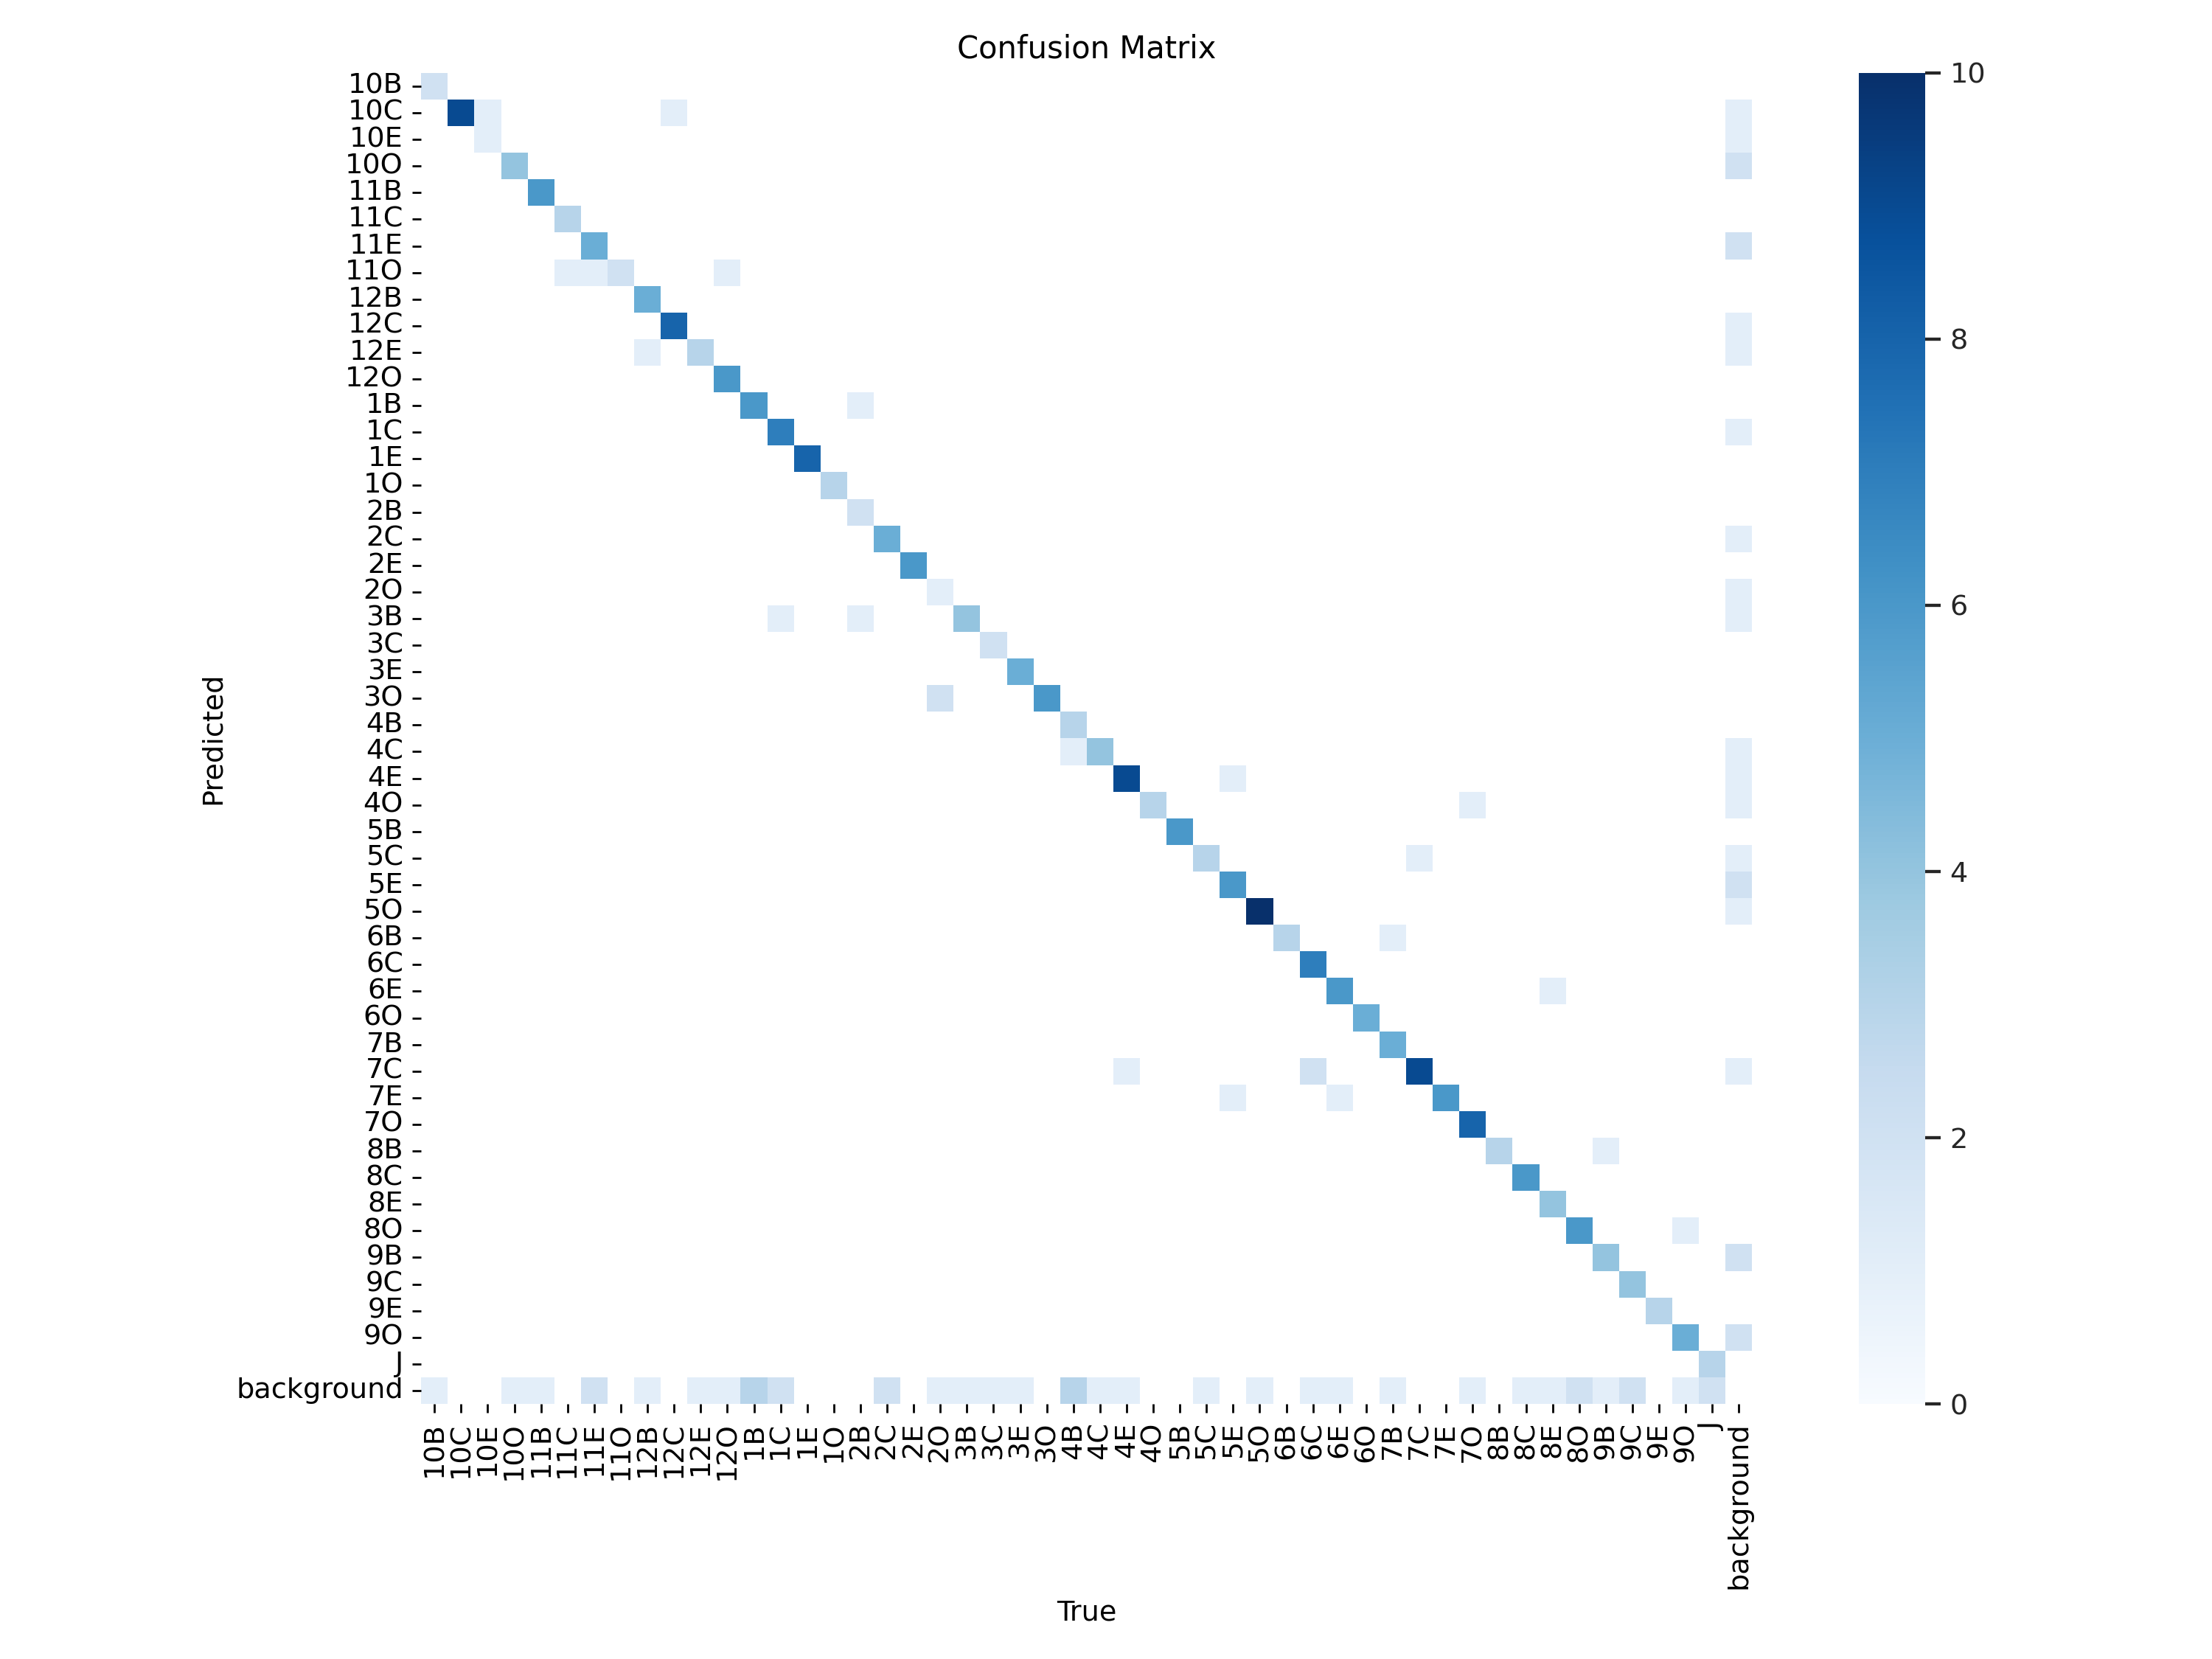

In [20]:
from PIL import Image
from IPython.display import display

image = Image.open('/kaggle/working/runs/detect/train/confusion_matrix.png')
display(image)

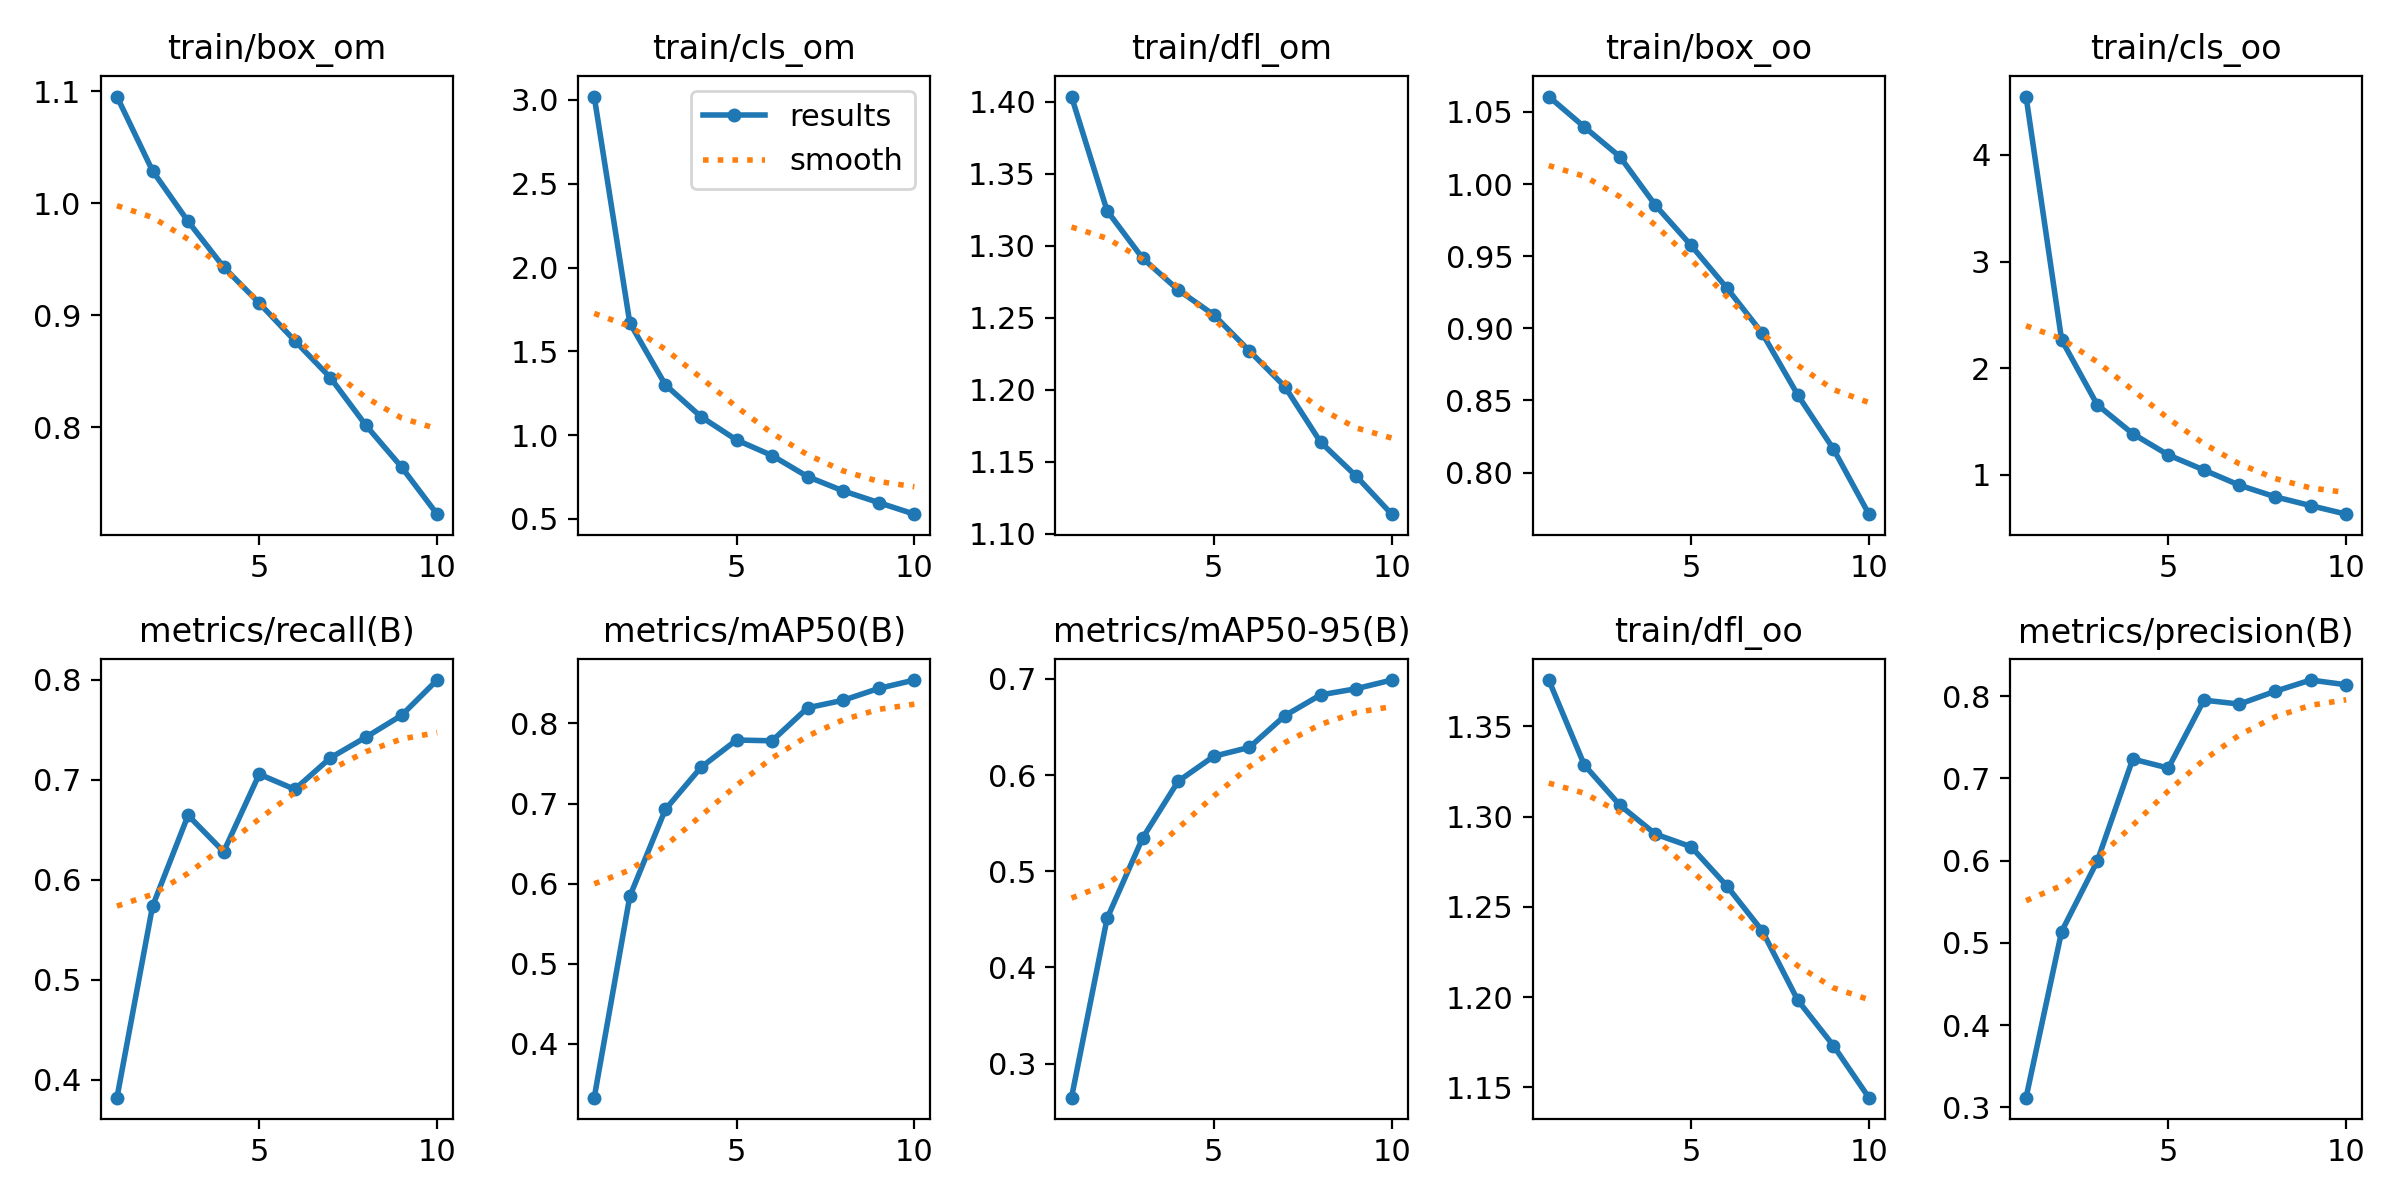

In [21]:
from PIL import Image
from IPython.display import display

image = Image.open('/kaggle/working/runs/detect/train/results.png')
display(image)

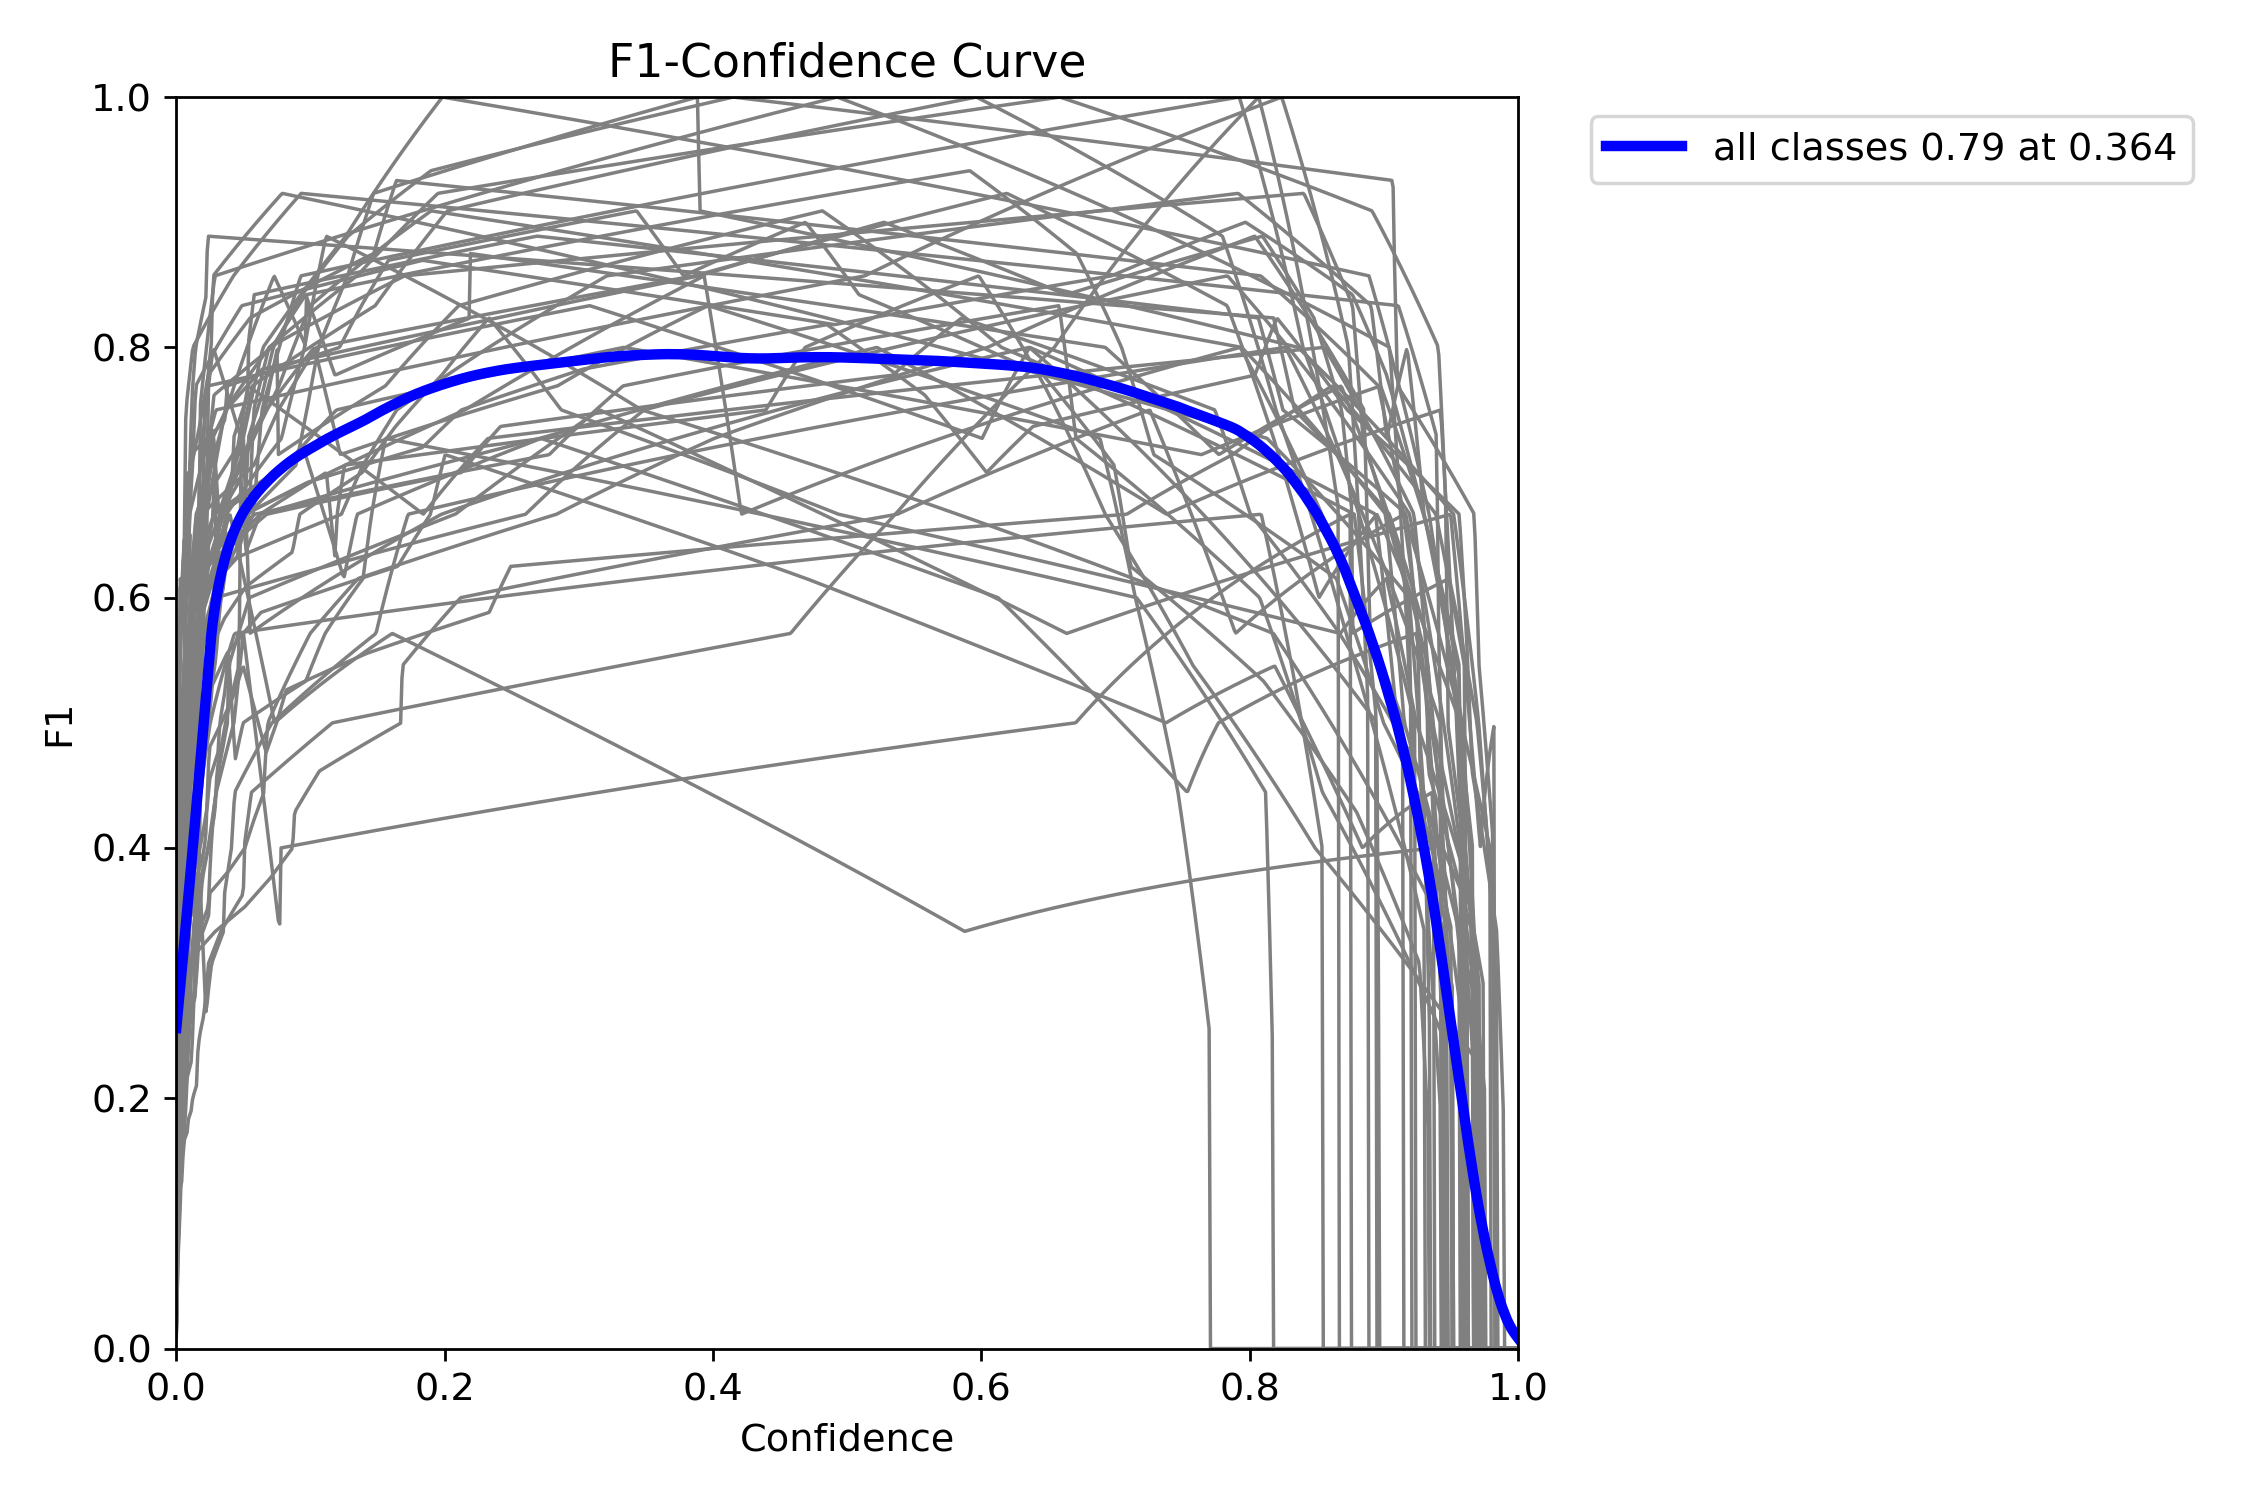

In [22]:
from PIL import Image
from IPython.display import display

image = Image.open('/kaggle/working/runs/detect/train/F1_curve.png')
display(image)